Anurag Sharma (24AI91R01)

# Task 1 - Data Preparation

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from collections import Counter

In [2]:
# Load diabetes dataset
diabetes_data = load_diabetes()
X = diabetes_data.data  # Features
y = diabetes_data.target  # Target variable

In [3]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

# Scale features for better performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training set size: 353
Test set size: 89


# Task 2 - From Scratch Implementation of Random Forest Regression

In [4]:
class DecisionTreeRegressor:
    def __init__(self, max_depth=5, max_features='sqrt', random_state=None):
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        if random_state is not None:
            np.random.seed(random_state)

    def fit(self, features, target):
        self.n_features_ = features.shape[1]
        if self.max_features == 'sqrt':
            self.max_features = int(np.sqrt(self.n_features_))
        self.tree_ = self._grow_tree(features, target)

    def _grow_tree(self, features, target, depth=0):
        n_samples, n_features = features.shape
        if depth >= self.max_depth or n_samples < 2:
            return self._mean_value(target)

        feature_indices = np.random.choice(n_features, size=self.max_features, replace=False)
        best_mse = float('inf')
        best_idx, best_thr = None, None

        # Find the best split
        for idx in feature_indices:
            thresholds, sorted_indices = np.unique(features[:, idx], return_index=True)
            for thr in thresholds:
                left_indices = features[:, idx] < thr
                right_indices = ~left_indices

                if np.any(left_indices) and np.any(right_indices):
                    left_mse = self._mse(target[left_indices])
                    right_mse = self._mse(target[right_indices])
                    mse = (len(target[left_indices]) * left_mse + len(target[right_indices]) * right_mse) / n_samples

                    if mse < best_mse:
                        best_mse = mse
                        best_idx = idx
                        best_thr = thr

        if best_mse == float('inf'):
            return self._mean_value(target)

        # Create child nodes
        left_indices = features[:, best_idx] < best_thr
        right_indices = ~left_indices
        left = self._grow_tree(features[left_indices], target[left_indices], depth + 1)
        right = self._grow_tree(features[right_indices], target[right_indices], depth + 1)
        return (best_idx, best_thr, left, right)

    def _mean_value(self, target):
        return np.mean(target)

    def _mse(self, target):
        if len(target) == 0:
            return 0
        return np.mean((target - np.mean(target)) ** 2)

    def predict(self, features):
        return np.array([self._predict(sample) for sample in features])

    def _predict(self, sample):
        node = self.tree_
        while isinstance(node, tuple):
            idx, thr, left, right = node
            if sample[idx] < thr:
                node = left
            else:
                node = right
        return node

class CustomRandomForestRegressor:
    def __init__(self, n_trees=100, max_depth=5, max_features='sqrt', random_state=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

    def fit(self, features, target):
        self.trees = []
        n_samples = features.shape[0]
        for i in range(self.n_trees):
            # Increment random state for each tree
            tree = DecisionTreeRegressor(max_depth=self.max_depth, max_features=self.max_features, random_state=self.random_state + i)
            bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
            tree.fit(features[bootstrap_indices], target[bootstrap_indices])
            self.trees.append(tree)

    def predict(self, features):
        tree_predictions = np.zeros((features.shape[0], self.n_trees))
        for i, tree in enumerate(self.trees):
            tree_predictions[:, i] = tree.predict(features)
        return np.mean(tree_predictions, axis=1)  # Average predictions from all trees

    def get_params(self, deep=True):
        """Get parameters for this estimator."""
        return {"n_trees": self.n_trees, "max_depth": self.max_depth, "max_features": self.max_features, "random_state": self.random_state}

    def set_params(self, **parameters):
        """Set the parameters of this estimator."""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Task 3 - Hyperparameter Tuning (From-Scratch Implementation)

In [5]:
# Initialize custom random forest regressor
custom_rf_regressor = CustomRandomForestRegressor(random_state=42)

# Define the parameter grid for grid search
param_grid = {'n_trees': [10, 50, 100, 200, 300]}
grid_search = GridSearchCV(estimator=custom_rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<__main__.CustomRandomForestRegressor object at 0x792eb8c56e30>,
             param_grid={'n_trees': [10, 50, 100, 200, 300]},
             scoring='neg_mean_squared_error')

In [6]:
# Get best number of trees
best_n_trees = grid_search.best_params_['n_trees']
print("Best number of trees:", best_n_trees)

Best number of trees: 300


In [7]:
# Fit the best model
best_custom_rf = CustomRandomForestRegressor(n_trees=best_n_trees, random_state=42)
best_custom_rf.fit(X_train, y_train)
y_pred_custom = best_custom_rf.predict(X_test)

# Calculate MSE for the custom model
mse_custom = mean_squared_error(y_test, y_pred_custom)
print("Mean Squared Error (MSE) on test set (custom):", mse_custom)

Mean Squared Error (MSE) on test set (custom): 2837.4164382763242


In [8]:
# Function to calculate out-of-bag (OOB) score
def calculate_oob_score(random_forest, X_train, y_train):
    n_samples = X_train.shape[0]
    oob_predictions = np.zeros(n_samples)
    oob_counts = np.zeros(n_samples)

    for tree in random_forest.trees:
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        oob_indices = np.setdiff1d(np.arange(n_samples), bootstrap_indices)

        if len(oob_indices) > 0:
            oob_preds = tree.predict(X_train[oob_indices])
            oob_predictions[oob_indices] += oob_preds
            oob_counts[oob_indices] += 1

    valid_indices = oob_counts > 0
    oob_predictions[valid_indices] /= oob_counts[valid_indices]

    # Calculate R2 score on OOB predictions
    oob_r2 = r2_score(y_train[valid_indices], oob_predictions[valid_indices])

    return oob_r2

In [9]:
# Calculate OOB score for the custom model
oob_custom = calculate_oob_score(best_custom_rf, X_train, y_train)
print("OOB score (scratch implementation):", oob_custom)

OOB score (scratch implementation): 0.7114643688088904


In [10]:
# Function to visualize decision tree
def plot_decision_tree(tree, feature_names, depth=0):
    if isinstance(tree, tuple):
        idx, thr, left, right = tree
        feature_name = feature_names[idx]
        # Plot decision node
        print('  ' * depth + f'if {feature_name} <= {thr}:')
        plot_decision_tree(left, feature_names, depth + 1)
        print('  ' * depth + f'else:')
        plot_decision_tree(right, feature_names, depth + 1)
    else:
        # Leaf node
        print('  ' * depth + f'Prediction: {tree}')

In [11]:
trees_to_visualize = [0, 1, 2, 3, 4]
for i in trees_to_visualize:
    print(f"Decision Tree {i + 1}:")
    plot_decision_tree(best_custom_rf.trees[i].tree_, [f'Feature {j}' for j in range(X_train.shape[1])])
    print()

Decision Tree 1:
if Feature 3 <= 0.498674385272663:
  if Feature 6 <= -0.19748185162076326:
    if Feature 7 <= 2.2575338553927735:
      if Feature 8 <= 0.28485741249623436:
        if Feature 8 <= -2.0445994820717304:
          Prediction: 201.0
        else:
          Prediction: 126.39024390243902
      else:
        if Feature 4 <= 0.3247822599922072:
          Prediction: 204.94444444444446
        else:
          Prediction: 140.45454545454547
    else:
      if Feature 5 <= 4.196352273913501:
        if Feature 0 <= -0.6999191602484154:
          Prediction: 137.0
        else:
          Prediction: 273.2857142857143
      else:
        Prediction: 84.0
  else:
    if Feature 8 <= 0.3312366034327375:
      if Feature 8 <= -0.6952131449479684:
        if Feature 2 <= -1.0129721479429488:
          Prediction: 110.5909090909091
        else:
          Prediction: 69.02564102564102
      else:
        if Feature 9 <= 0.5387106400296962:
          Prediction: 98.93548387096774
    

# Task 4 - Scikit-learn Implementation

In [12]:
# Create a RandomForestRegressor model
sklearn_rf_regressor = RandomForestRegressor(random_state=42)

In [13]:
# Define the parameter grid for GridSearchCV
param_grid_sklearn = {'n_estimators': [10, 50, 100, 200, 300]}

# Create a GridSearchCV object
grid_search_sklearn = GridSearchCV(estimator=sklearn_rf_regressor, param_grid=param_grid_sklearn, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search_sklearn.fit(X_train, y_train)

# Print the best number of trees
print("Best number of trees (scikit-learn):", grid_search_sklearn.best_params_['n_estimators'])

Best number of trees (scikit-learn): 300


In [14]:
# Create a RandomForestRegressor model with the best number of trees
best_sklearn_rf = RandomForestRegressor(n_estimators=grid_search_sklearn.best_params_['n_estimators'], oob_score=True)

# Fit the model to the training data
best_sklearn_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_sklearn = best_sklearn_rf.predict(X_test)

# Calculate the MSE on the test set for scikit-learn model
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
print("Mean Squared Error (MSE) on test set (scikit-learn):", mse_sklearn)

# Get the OOB score
oob_score_sklearn = best_sklearn_rf.oob_score_
print("OOB score (scikit-learn):", 1 - oob_score_sklearn)

Mean Squared Error (MSE) on test set (scikit-learn): 2998.8424586766546
OOB score (scikit-learn): 0.5533250324958693


In [15]:
# this will take a long time to run
# # Visualize decision trees from scikit-learn implementation
# n_estimators = len(best_sklearn_rf.estimators_)
# fig, axes = plt.subplots(n_estimators, 1, figsize=(20, 20))
# for i, estimator in enumerate(best_sklearn_rf.estimators_):
#     plot_tree(estimator, ax=axes[i])
#     axes[i].set_title('Decision Tree {}'.format(i + 1))
# plt.tight_layout()
# plt.show()

Task 5 - Comparison and Visualization

In [23]:
print("Best number of trees (scratch implementation):", best_n_trees)
print("OOB score (scratch implementation):", oob_custom)
print("===========================================")
print("Best number of trees (scikit-learn):", grid_search_sklearn.best_params_['n_estimators'])
print("OOB score (scikit-learn):", 1 - oob_score_sklearn)
print("===========================================")
# Compare Mean Squared Error values
print("MSE from scratch implementation:", mse_custom)
print("MSE from scikit-learn implementation:", mse_sklearn)
print("===========================================")

if mse_custom < mse_sklearn:
    print("Scratch implementation has lower MSE.")
elif mse_custom > mse_sklearn:
    print("Scikit-learn implementation has lower MSE.")
else:
    print("Both implementations have the same MSE.")

Best number of trees (scratch implementation): 300
OOB score (scratch implementation): 0.7114643688088904
Best number of trees (scikit-learn): 300
OOB score (scikit-learn): 0.5533250324958693
MSE from scratch implementation: 2837.4164382763242
MSE from scikit-learn implementation: 2998.8424586766546
Scratch implementation has lower MSE.


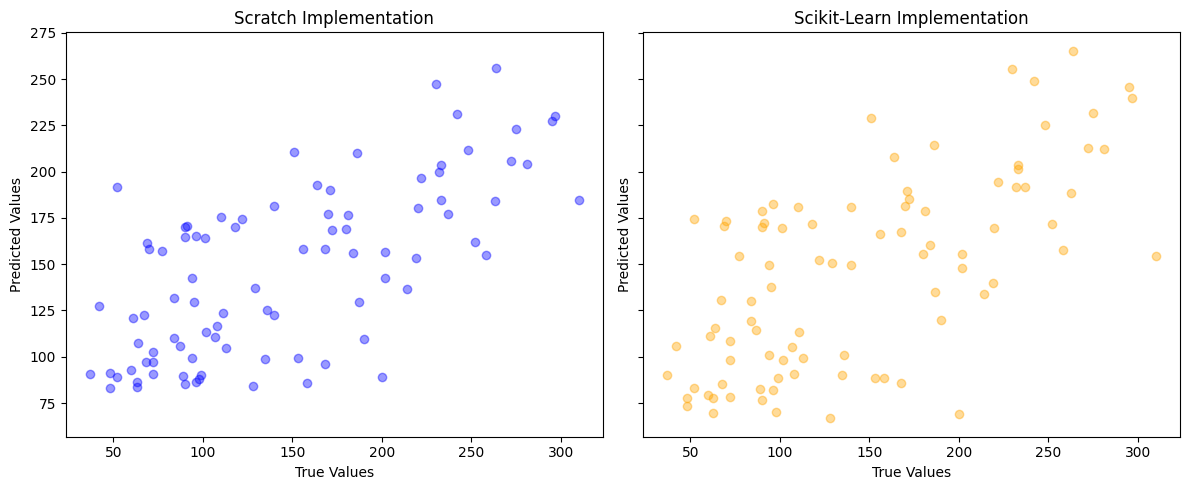

In [17]:
# Scatter plot to visualize predictions vs true values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Scatter plot for custom implementation
ax1.scatter(y_test, y_pred_custom, color='blue', alpha=0.4)
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predicted Values")
ax1.set_title("Scratch Implementation")

# Scatter plot for scikit-learn implementation
ax2.scatter(y_test, y_pred_sklearn, color='orange', alpha=0.4)
ax2.set_xlabel("True Values")
ax2.set_ylabel("Predicted Values")
ax2.set_title("Scikit-Learn Implementation")

plt.tight_layout()
plt.show()